# LIGO - Gravitational Waves simple classification - Part 1

This is our final work for the "Seminario intensivo de topicos avanzados en datos complejos" (Intensive seminar in advanced topics of complex data). We pretend to download a pre-classified set of gravitational waves provided by the LIGO observatory (Both, Livingston and Hanford observatories) during its first and second observatory run (O1 and O2).
This dataset is part of the whole Gravity Spy paper and libraries, this is the set for which that project's convolutional networks were trained. (For more data on the subject, please refer to ["Gravity Spy - Integrated Advanced LIGO detector characterization machine learning and citizen science"](https://arxiv.org/abs/1611.04596).). Since the dataset size isn't trivial, we provide you the original place from which it can be [dowloaded](https://zenodo.org/record/1486046#.XrLYbi-ZMSQ).

> Please, keep in mind that this work is the first stone in the way of my specialization's final work; which will entail the work over the classification of gravitational waves using convolutional neural networks.

> Take into account, that this whole notebook, datasets and scripts doesn't runs in the course's docker images preset for spark. We have changed the /spark/Dockerfile in order to generate the due versions. The Docker-Compose.yaml file has been updated to work with this very image, as well.

The data set is divided in three parts:

There are three files provided in this data set

- trainingset_v1d1_metadata.csv

This file has many columns, gravityspy_id, label, and sample_type. 
*gravityspy_id* is the unique 10 character hash given to every Gravity Spy sample. 
*label* is the string label of the sample. 
*sample_type* indicates whether this sample was used in the paper for testing training or validating the models. This is provided for those who would like to do direct comparisons to the network described in the paper.
Additional columns contain some metadata information about the "glitchs".

- trainingsetv1d1.h5

This file contains the exact arrays used in the paper for every Gravity Spy sample. Each Gravity Spy sample is defined by four different images with varying temporal duration, 0.5, 1.0, 2.0, and 4.0 second, respectively. 
This file contains all the information needed for each sample in the Gravity Spy dataset.

- trainingsetv1d1.tar.gz

Contains the raw PNGs of the Gravity Spy training set.
The structure of the folder is /"label"/"sample_type"/"pngs", and is the same information you could find in the HDF5 file above.

## What we are going to do

We are going to divide this work in two parts:

1. Merge the images with the data in the csv file, so we have a simple spark dataframe to operate with. We call this task "regularization", or "nomalization" of the data. This notebook will resolve this step and show up our exploration process. However, the script that will do the heavy lifting will be: *generate_gw_dataset.py* which will do the very same things that does this whole notebook, but with the whole dataset, not the first 30th rows.

2. We are going to load up this dataframe and apply at least one classifier over the data with the intention of identifying "Chrips" and "no-chrips". Keep in mind that the "Chirps" according to the referenced paper, are "Gravitational Waves". All the other are just noise resembling them. This is going to be resolved in a different notebook and python's script.





In [2]:
import numpy as np
import h5py
import os
from gwpy.timeseries import TimeSeries

In [ ]:
#Getting the correct path
os.getcwd()


In [3]:
hd5f_file='/dataset/trainingsetv1d1.h5'

In [4]:
hf = h5py.File(hd5f_file, 'r')


In [54]:
list(hf.keys())


['1080Lines',
 '1400Ripples',
 'Air_Compressor',
 'Blip',
 'Chirp',
 'Extremely_Loud',
 'Helix',
 'Koi_Fish',
 'Light_Modulation',
 'Low_Frequency_Burst',
 'Low_Frequency_Lines',
 'No_Glitch',
 'None_of_the_Above',
 'Paired_Doves',
 'Power_Line',
 'Repeating_Blips',
 'Scattered_Light',
 'Scratchy',
 'Tomte',
 'Violin_Mode',
 'Wandering_Line',
 'Whistle']

In [5]:
#Example of reading the dataset with Pandas
import pandas as pd

#first, we get the dataframe in pandas with all the headers for the data.
csv = '/dataset/trainingset_v1d1_metadata.csv'
df=pd.read_csv(csv, sep=',',header=0)

df.head()

,event_time,ifo,peak_time,peak_time_ns,start_time,start_time_ns,duration,search,process_id,event_id,...,chisq_dof,param_one_name,param_one_value,gravityspy_id,label,sample_type,url1,url2,url3,url4
0,1.134216e+09,L1,1134216192,931639909,1134216192,832031011,0.18750,Omicron,0,21,...,0,phase,-2.72902,zmIdpucyOG,Whistle,train,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
1,1.129360e+09,L1,1129359781,558593034,1129359781,47851085,0.94238,Omicron,0,107,...,0,phase,1.10682,zWFRqqDxwv,Whistle,test,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
2,1.127425e+09,L1,1127425468,976317882,1127425468,960937023,0.04688,Omicron,0,218,...,0,phase,-0.83099,zKCTakFVcf,Whistle,train,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
3,1.132637e+09,L1,1132636755,365233898,1132636754,951172113,0.82422,Omicron,0,88,...,0,phase,0.76242,z14BdoiFZS,Whistle,validation,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
4,1.132036e+09,L1,1132035853,197264909,1132035852,933837890,2.00366,Omicron,0,16,...,0,phase,-0.31161,yyjqLCtAmO,Whistle,validation,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...


In [5]:
#now, we test the idea of disecting the CSV
gravityspy_id= df['gravityspy_id'][0]
label= df['label'][0]
sample_type= df['sample_type'][0]

png = hf[label][sample_type][gravityspy_id]['0.5.png']
png = png[0]
png.shape

(140, 170)

<function matplotlib.pyplot.show>

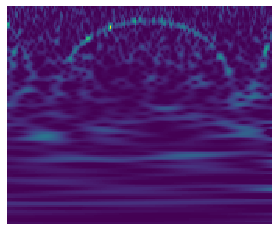

In [10]:
#This snippet was used to understand how to render the image.
import matplotlib.pyplot as plt

plt.imshow(png)

plt.axis('off')
plt.show


In [3]:
# Spark version
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("pyspark-gw").getOrCreate()

print(spark.version)


2.4.5


In [12]:
# Example of reading the dataset with Spark
csv = '/dataset/trainingset_v1d1_metadata.csv'
df = spark.read.csv(csv, header=True)


In [5]:
df.shape

(7966, 28)

In [6]:
#forming a new dataset
gwdf = df[0:30] #we reduce the set of data to test the algorithm at a fast rate.

print(gwdf.shape)
print(str(type(gwdf)))
print(gwdf.columns)

gvtyid = 21
labelid = 22
sampleid=23

gwdf.shape[0]
gwdf['png'] = ''#pd.DataFrame({}) 

print(gwdf.shape)
print(gwdf['png'])


for index, record in gwdf.iterrows():
    gravityspy_id= record[gvtyid]
    label= record[labelid]
    sample_type= record[sampleid]
    
    png = np.array(hf[label][sample_type][gravityspy_id]['0.5.png'][0])
    
    png = np.reshape(png,23800).tolist() #we place the whole image in just one dimension array.
    
    gwdf.at[index, 'png'] = png

#gwdf.to_csv('/dataset/gw_gravity_spy_dataframe.csv') #<-We tested this approach as well, but the png array was summarized.
#gwdf.to_pickle('/dataset/test.pickle') #<- we tested this approach, but way too many record were saved as null values.


(30, 28)
<class 'pandas.core.frame.DataFrame'>
Index(['event_time', 'ifo', 'peak_time', 'peak_time_ns', 'start_time',
       'start_time_ns', 'duration', 'search', 'process_id', 'event_id',
       'peak_frequency', 'central_freq', 'bandwidth', 'channel', 'amplitude',
       'snr', 'confidence', 'chisq', 'chisq_dof', 'param_one_name',
       'param_one_value', 'gravityspy_id', 'label', 'sample_type', 'url1',
       'url2', 'url3', 'url4'],
      dtype='object')
(30, 29)
0     
1     
2     
3     
4     
5     
6     
7     
8     
9     
10    
11    
12    
13    
14    
15    
16    
17    
18    
19    
20    
21    
22    
23    
24    
25    
26    
27    
28    
29    
Name: png, dtype: object


/root/miniconda3/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
import findspark

findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext


spark = SparkSession.builder.appName("pyspark-gw").getOrCreate()

sqlCtx = SQLContext(spark)
sdf = sqlCtx.createDataFrame(gwdf) #getting a spark dataframe out of a Pandas dataframe.

In [68]:
sdf.head() #we test to see if the set is as such.

Row(event_time=1134216192.9316401, ifo='L1', peak_time=1134216192, peak_time_ns=931639909, start_time=1134216192, start_time_ns=832031011, duration=0.1875, search='Omicron', process_id=0, event_id=21, peak_frequency=1337.6953125, central_freq=1120.04321289062, bandwidth=573.363952636719, channel='GDS-CALIB_STRAIN', amplitude=1.1976500147017298e-22, snr=7.511390209198001, confidence=0, chisq=0, chisq_dof=0, param_one_name='phase', param_one_value=-2.7290200000000002, gravityspy_id='zmIdpucyOG', label='Whistle', sample_type='train', url1='https://panoptes-uploads.zooniverse.org/production/subject_location/e0a29b6e-30da-4b83-a823-d84262e5f32b.png', url2='https://panoptes-uploads.zooniverse.org/production/subject_location/ccf7f147-a727-46e6-95ec-65f3c7b619f8.png', url3='https://panoptes-uploads.zooniverse.org/production/subject_location/1a3a0247-6b62-4f64-884f-387348c0557f.png', url4='https://panoptes-uploads.zooniverse.org/production/subject_location/0ffb52cb-ad48-4ae9-b120-a8aa5aa3d77b.p

In [13]:
unpickled_df = pd.read_pickle("/dataset/test.pickle")
unpickled_df

,event_time,ifo,peak_time,peak_time_ns,start_time,start_time_ns,duration,search,process_id,event_id,...,param_one_name,param_one_value,gravityspy_id,label,sample_type,url1,url2,url3,url4,png
0,1.134216e+09,L1,1134216192,931639909,1134216192,832031011,0.18750,Omicron,0,21,...,phase,-2.72902,zmIdpucyOG,Whistle,train,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,"[0.10231367, 0.13103157, 0.14924803, 0.1039726..."
1,1.129360e+09,L1,1129359781,558593034,1129359781,47851085,0.94238,Omicron,0,107,...,phase,1.10682,zWFRqqDxwv,Whistle,test,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,"[0.086593725, 0.086593725, 0.11495804, 0.12481..."
2,1.127425e+09,L1,1127425468,976317882,1127425468,960937023,0.04688,Omicron,0,218,...,phase,-0.83099,zKCTakFVcf,Whistle,train,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,"[0.1650454, 0.096691765, 0.13029973, 0.0832227..."
3,1.132637e+09,L1,1132636755,365233898,1132636754,951172113,0.82422,Omicron,0,88,...,phase,0.76242,z14BdoiFZS,Whistle,validation,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,"[0.24178803, 0.15504831, 0.16901046, 0.1666115..."
4,1.132036e+09,L1,1132035853,197264909,1132035852,933837890,2.00366,Omicron,0,16,...,phase,-0.31161,yyjqLCtAmO,Whistle,validation,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,"[0.13052422, 0.097796924, 0.13480349, 0.207155..."
5,1.163422e+09,H1,1163421591,621093034,1163421591,492187023,0.38281,OMICRON,0,228,...,phase,1.56686,tsUHxRhgQU,1080Lines,train,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,"[0.13052422, 0.121122606, 0.0988869, 0.0916618..."
6,1.135087e+09,L1,1135086850,427246093,1135086850,310547113,0.70312,Omicron,0,78,...,phase,0.50844,yZPB2Lkecd,Whistle,validation,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,"[0.30458266, 0.2807377, 0.124193706, 0.0922156..."
7,1.136285e+09,L1,1136285262,929687023,1136285262,976085,1.62012,Omicron,0,0,...,phase,0.01421,yKsXudIzbX,Whistle,train,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,"[0.12370349, 0.09166182, 0.11043775, 0.1335218..."
8,1.132651e+09,L1,1132651216,955077886,1132651216,0,1.24512,Omicron,0,92,...,phase,1.13611,xo7m4GKIOx,Whistle,train,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,"[0.1071072, 0.155646, 0.11645582, 0.08377655, ..."
9,1.132637e+09,L1,1132637476,677733898,1132637476,342772960,0.74317,Omicron,0,84,...,phase,-1.97719,xmxiRoeHxh,Whistle,test,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,"[0.08377655, 0.09553355, 0.10988048, 0.0860399..."


In [72]:
#We use the spark dataset to write its contents (all the gravity spy's dataset) to a partquet file for easy classification. 
sdf.write.parquet('/dataset/gw_gravity_spy_dataframe_test.parquet')

In [74]:
parquet_df = spark.read.parquet('/dataset/gw_gravity_spy_dataframe_test.parquet')
parquet_df.head()

Row(event_time=1163850760.01758, ifo='L1', peak_time=1163850760, peak_time_ns=17577886, start_time=1163850759, start_time_ns=968750000, duration=0.125, search='OMICRON', process_id=0, event_id=163, peak_frequency=1540.77734375, central_freq=1837.2570800781198, bandwidth=2711.09765625, channel='GDS-CALIB_STRAIN', amplitude=5.167969911283529e-22, snr=13.6570596694946, confidence=0, chisq=0, chisq_dof=0, param_one_name='phase', param_one_value=-2.30207, gravityspy_id='msSTHcULv9', label='Violin_Mode', sample_type='train', url1='https://panoptes-uploads.zooniverse.org/production/subject_location/b8c5da87-67b5-4ed9-b6fd-65bb2b916179.png', url2='https://panoptes-uploads.zooniverse.org/production/subject_location/cca146ea-47e4-4ee4-b6c3-6b8a3d2d893b.png', url3='https://panoptes-uploads.zooniverse.org/production/subject_location/663f27b5-1757-4261-922b-9c43b6b0be30.png', url4='https://panoptes-uploads.zooniverse.org/production/subject_location/8953dc2d-ae15-4dae-9d74-e5dd110ecdfb.png', png=[0.

# Reforming the dataset into 14 blocks of 569 records ( array size 7966) - 1st block

In [7]:
# Since /code/gw/generate_gw_dataset.py can't handle a block so huge of memory to store it as parquet, 
# we will try re factoring it into blocks.
import findspark

findspark.init()

from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

#forming a new dataset - for the first block
block_number = 1
block = 569
begin = 0
end = block * block_number
gwdf = df[begin:end] #we reduce the set of data to test the algorithm at a fast rate.

print(gwdf.shape)
print(str(type(gwdf)))
print(gwdf.columns)

gvtyid = 21
labelid = 22
sampleid=23

# Adds a new columns
gwdf.shape[0]
gwdf['png'] = '' 

print(gwdf.shape)
#print(gwdf['png'])


for index, record in gwdf.iterrows():
    gravityspy_id= record[gvtyid]
    label= record[labelid]
    sample_type= record[sampleid]
    
    png = np.array(hf[label][sample_type][gravityspy_id]['0.5.png'][0])
    
    png = Vectors.dense(np.reshape(png,23800).tolist()) #we place the whole image in just one dimension array.
    
    gwdf.at[index, 'png'] = png



(569, 28)
<class 'pandas.core.frame.DataFrame'>
Index(['event_time', 'ifo', 'peak_time', 'peak_time_ns', 'start_time',
       'start_time_ns', 'duration', 'search', 'process_id', 'event_id',
       'peak_frequency', 'central_freq', 'bandwidth', 'channel', 'amplitude',
       'snr', 'confidence', 'chisq', 'chisq_dof', 'param_one_name',
       'param_one_value', 'gravityspy_id', 'label', 'sample_type', 'url1',
       'url2', 'url3', 'url4'],
      dtype='object')
(569, 29)


/root/miniconda3/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
#Going into spark context to save it all as a parquet format.
spark = SparkSession.builder.appName("pyspark-gw").getOrCreate()

sqlCtx = SQLContext(spark)
sdf = sqlCtx.createDataFrame(gwdf) #getting a spark dataframe out of a Pandas dataframe.

#We just save the first blocks...they are known to be seven!
sdf.write.format("parquet") \
.partitionBy("gravityspy_id","label","sample_type") \
.option("path", "/dataset/gw_gravity_spy_dataframe_test") \
.mode("overwrite") \
.saveAsTable("gw_gravity_spy_test")

print("Saved succesfully")

Saved succesfully


In [12]:
# This tests if we can re load it.
parquet_df = spark.read.parquet('/dataset/gw_gravity_spy_dataframe_test')
parquet_df.head()

Row(event_time=1127316933.86035, ifo='H1', peak_time=1127316933, peak_time_ns=860351085, start_time=1127316933, start_time_ns=836914062, duration=0.6152300238609311, search='Omicron', process_id=0, event_id=214, peak_frequency=1181.22387695312, central_freq=1242.05822753906, bandwidth=2405.51831054688, channel='GDS-CALIB_STRAIN', amplitude=1.8502000469038799e-22, snr=11.189049720764197, confidence=0, chisq=0, chisq_dof=0, param_one_name='phase', param_one_value=-0.22053000000000003, url1='https://panoptes-uploads.zooniverse.org/production/subject_location/5b5bc81b-feba-4da6-94b0-97f24fe2d167.png', url2='https://panoptes-uploads.zooniverse.org/production/subject_location/285db5f3-5a63-4f47-a958-1c453760e358.png', url3='https://panoptes-uploads.zooniverse.org/production/subject_location/e657905e-b86a-4c28-bad3-73d219c379f9.png', url4='https://panoptes-uploads.zooniverse.org/production/subject_location/f2f9ad17-803b-446d-9a9c-d913c90cf8de.png', png=[0.09503280371427536, 0.1211226060986518

In [ ]:
spark.stop()

# Continue...

For looking after part 2, please go for the notebook "LIGO - Training classifier to identify Gravitational Waves.ipynb"*